In [20]:
import pandas as pd
from gensim.models import KeyedVectors, Word2Vec
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, random_split
import pickle
import matplotlib.pyplot as plt

In [21]:
df_text = pd.read_pickle('./data/clean_title_text.pkl')
model_text = Word2Vec( df_text["tokens"],vector_size=100)
print("text: {0}".format(model_text.corpus_total_words))
model_text.wv.save_word2vec_format("./data/model_text")
print(df_text.shape)

text: 23187010
(72100, 3)


In [22]:
merged_keyed_vectors = KeyedVectors.load_word2vec_format("./data/model_text")

2
243.0
12434
812.0


(array([1.5808e+04, 2.1656e+04, 1.4808e+04, 7.5390e+03, 4.5840e+03,
        3.0570e+03, 1.7490e+03, 9.1400e+02, 4.6500e+02, 3.4300e+02,
        1.9400e+02, 1.9600e+02, 1.1500e+02, 8.5000e+01, 8.5000e+01,
        7.2000e+01, 4.5000e+01, 5.0000e+01, 4.5000e+01, 4.6000e+01,
        2.9000e+01, 2.3000e+01, 1.6000e+01, 2.1000e+01, 2.7000e+01,
        1.3000e+01, 1.5000e+01, 5.0000e+00, 7.0000e+00, 1.1000e+01,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+01, 3.0000e+00,
        6.0000e+00, 7.0000e+00, 3.0000e+00, 4.0000e+00, 4.0000e+00,
        3.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.00

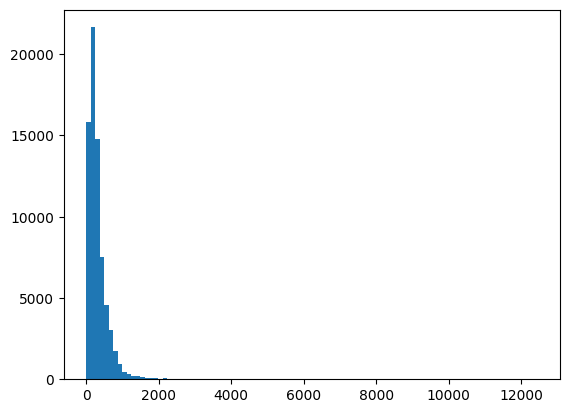

In [23]:
lengths = df_text['tokens'].apply(lambda x: len(x))

# Calculate the median length
median_length = lengths.median()
max_length = lengths.max()
min_length = lengths.min()

truncate_length = int(lengths.quantile(0.95))

print(min_length)
print(median_length)
print(max_length)
print(lengths.quantile(0.95))


plt.hist(lengths,bins=100)


In [24]:
# test with smaller amount of data
FRACTION = 1
size = int(df_text.shape[0] * FRACTION)
print(size)


# make tensors
def text_to_tensor(text_list, merged_keyed_vectors,truncate_length):
    vectors = [merged_keyed_vectors[word] for word in text_list[:truncate_length+1] if word in merged_keyed_vectors]
    return torch.tensor(vectors)


def stack_tensor(df: pd.DataFrame, col_name, word_model,truncate_length):
    tensor_ls = []
    label_ls = []
    for row in df.itertuples(index=False):
        # print(row[df.columns.get_loc('class')])
        # print(row[df.columns.get_loc(col_name)])
        label_ls.append(row[df.columns.get_loc("class")])
        tensor_ls.append(text_to_tensor(row[df.columns.get_loc(col_name)], word_model, truncate_length=truncate_length))
    padded_ls = pad_sequence(tensor_ls, batch_first=True)
    return torch.tensor(label_ls), torch.stack(tuple(padded_ls))


text_labels_tensor, text_tensor = stack_tensor(
    df_text.iloc[:size, :], 
    col_name="tokens", 
    word_model=merged_keyed_vectors,
    truncate_length=truncate_length
)
print(text_tensor.size())
print(text_labels_tensor.size())
text_dataset = TensorDataset(text_tensor, text_labels_tensor)

72100
torch.Size([72100, 813, 100])
torch.Size([72100])


In [25]:
def split(tensor_dataset, test_split=0.2):
    test_size = int(len(tensor_dataset) * test_split)
    train_size = int(len(tensor_dataset) - test_size)
    train_data, test_data = random_split(tensor_dataset, [train_size, test_size])
    print(f'total_size {len(tensor_dataset)}')
    print(f'train_size {len(train_data)}')
    print(f'test_size {len(test_data)}')
    return train_data, test_data

train_text_tensor, test_text_tensor = split(text_dataset,0.2)

# with open("./data/train_merged","wb") as f:
#     pickle.dump(train_text_tensor,f)
# with open("./data/test_merged","wb") as f:
#     pickle.dump(test_text_tensor,f)


total_size 72100
train_size 57680
test_size 14420


In [26]:
import torch
import pickle
from torch import nn
from torch.utils.data import DataLoader

batch_size=32
train_text_data = DataLoader(train_text_tensor, batch_size=batch_size, shuffle=True)
test_text_data = DataLoader(test_text_tensor, batch_size=batch_size, shuffle=True)

# check batch dimension
batch_size = train_text_data.batch_size
for data, label in train_text_data:
    print("shape: {0}".format(data.size()))
    break
sequence_length = data.size()[1]
print(batch_size)

shape: torch.Size([32, 813, 100])
32


In [27]:
gpu = torch.device("mps")
class RNNClassifier(nn.Module):
    def __init__(
        self, hidden_size, input_size, num_layers, num_classes, dropout, activation_fn
    ):
        super(RNNClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.nonlinearity = activation_fn

    def forward(self, x):
        # Initialize hidden state with random values.
        h0 = torch.randn(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(gpu)

        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        out = self.dropout(out)
        out = self.nonlinearity(out)
        out_distribution = nn.functional.log_softmax(out, dim=-1)
        return out_distribution


def train(
    train_dataloader, test_dataloader, loss_criterion, num_epochs, model, optimizer
):
    # A counter for the number of gradient updates we've performed.
    num_iter = 0

    # Iterate `num_epochs` times.
    for epoch in range(num_epochs):
        print("Starting epoch {}".format(epoch + 1))
        # Iterate over the train_dataloader, unpacking the images and labels
        for data, labels in train_dataloader:
            # If we're using the GPU, move reshaped_images and labels to the GPU.
            if gpu:
                data = data.to(gpu)
                labels = labels.to(gpu)

            # Run the forward pass through the model to get predicted log distribution.
            predicted = model(data)

            # Calculate the loss
            batch_loss = loss_criterion(predicted, labels)

            # Clear the gradients as we prepare to backprop.
            optimizer.zero_grad()

            # Backprop (backward pass), which calculates gradients.
            batch_loss.backward()

            # Take a gradient step to update parameters.
            optimizer.step()

            # Increment gradient update counter.
            num_iter += 1

            # Calculate test set loss and accuracy every 100 gradient updates
            # It's standard to have this as a separate evaluate function, but
            # we'll place it inline for didactic purposes.
            if num_iter % 1000 == 0:
                # Set model to eval mode, which turns off dropout.
                model.eval()
                # Counters for the num of examples we get right / total num of examples.
                num_correct = 0
                total_examples = 0
                total_test_loss = 0

                with torch.no_grad():
                    # Iterate over the test dataloader
                    for test_data, test_labels in test_dataloader:

                        # If we're using the GPU, move tensors to the GPU.
                        if gpu:
                            test_data = test_data.to(gpu)
                            test_labels = test_labels.to(gpu)

                        # Run the forward pass to get predicted distribution.
                        predicted = model(test_data)

                        # Calculate loss for this test batch. This is averaged, so multiply
                        # by the number of examples in batch to get a total.
                        total_test_loss += loss_criterion(
                            predicted, test_labels
                        ).data * test_labels.size(0)

                        # Get predicted labels (argmax)
                        _, predicted_labels = torch.max(predicted.data, 1)

                        # Count the number of examples in this batch
                        total_examples += test_labels.size(0)

                        # Count the total number of correctly predicted labels.
                        # predicted == labels generates a ByteTensor in indices where
                        # predicted and labels match, so we can sum to get the num correct.
                        num_correct += torch.sum(predicted_labels == test_labels.data)
                accuracy = 100 * num_correct / total_examples
                average_test_loss = total_test_loss / total_examples
                print(
                    "Iteration {}. Test Loss {}. Test Accuracy {}.".format(
                        num_iter, average_test_loss, accuracy
                    )
                )
                # Set the model back to train mode, which activates dropout again.
                model.train()
    return model

In [28]:
activation_fn = nn.ReLU()
model = RNNClassifier(
    hidden_size=128, input_size=100, num_layers=1, num_classes=2, dropout=0.5, activation_fn=activation_fn
)
loss_criterion = nn.NLLLoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.0001)
model.to(gpu)

RNNClassifier(
  (gru): GRU(100, 128, batch_first=True)
  (fc): Linear(in_features=104064, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (nonlinearity): ReLU()
)

In [29]:
num_epochs = 10
print(f"batch size:{batch_size}")
model = train(
    train_text_data, 
    test_text_data, 
    loss_criterion, 
    num_epochs, 
    model, 
    optimiser
)
with open("./data/model","wb") as f:
    torch.save(model,f)

batch size:32
Starting epoch 1


Iteration 1000. Test Loss 0.45920586585998535. Test Accuracy 92.45492553710938.
Starting epoch 2
Iteration 2000. Test Loss 0.4278078079223633. Test Accuracy 94.02912902832031.
Iteration 3000. Test Loss 0.4349280595779419. Test Accuracy 94.09847259521484.
Starting epoch 3
Iteration 4000. Test Loss 0.41848501563072205. Test Accuracy 94.9930648803711.
Iteration 5000. Test Loss 0.4141189157962799. Test Accuracy 94.81969451904297.
Starting epoch 4
Iteration 6000. Test Loss 0.4041016101837158. Test Accuracy 95.53398132324219.
Iteration 7000. Test Loss 0.1282380223274231. Test Accuracy 95.59639739990234.
Starting epoch 5
Iteration 8000. Test Loss 0.11466962099075317. Test Accuracy 95.77669525146484.
Iteration 9000. Test Loss 0.11623404175043106. Test Accuracy 95.8460464477539.
Starting epoch 6
Iteration 10000. Test Loss 0.10595009475946426. Test Accuracy 95.99861145019531.
Starting epoch 7
Iteration 11000. Test Loss 0.10443523526191711. Test Accuracy 95.92926788330078.
Iteration 12000. Test L